# Semantic Segmentation DRF Service Recommendation Engine

In order to recommend Data Reasoning Fabric services to Advaned Air Mobility Vehicles, semantic segmentation using Word2Vec Tokenization and BERT are deployed. The model architecture was evaluated on a dataset of 30,000+ weather conditions, with the final model being trained on a combination of 500 curated phrases and NOTAMs. 

In [1]:
!pip install simpletransformers

Import all necessary libraries and submodules

In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import os
import time
import logging
import torch
import sklearn
from simpletransformers.classification import ClassificationModel, ClassificationArgs

2022-04-18 12:15:19.567559: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-04-18 12:15:19.567573: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


# Data Importing and PreProcessing

The dataset is then imported into a Pandas dataframe object, with the labels as integers

In [5]:
path = 'daily_weather_training_data_normalized.csv'

if(os.path.exists(path)):
  print('File Found:', path)
  df = pd.read_csv(path, usecols=['text', 'label'], low_memory=True, dtype=str, encoding='utf-8')
  df.head()
else:
  print("No File Found")

File Found: daily_weather_training_data_normalized.csv


Force Wrap the datatypes

In [6]:
df['labels'] = df['label'].astype(int)
df['text'] = df['text'].astype(str)

Visualize the dataset and ensure the correct number of labels are present. Standard bar graph visualizations are used for efficient data visualization. This helps validate the efficacy of the dataset.

/home/kamran/Documents/bert-model-eval/venv/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='labels', ylabel='count'>

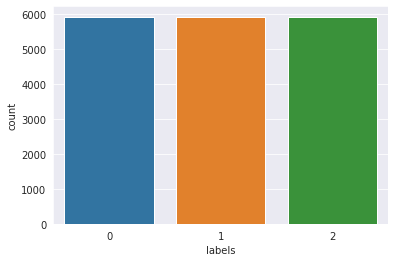

In [7]:
df['labels'].value_counts()
sns.countplot(df.labels)

Split into test and training dataframes

In [8]:
train,eval = train_test_split(df.astype(str),test_size=0.1)

The test and training datasets are then prepared and the data is converted to that format. 

In [9]:
train_df = pd.DataFrame({
    'text': train['text'],
    'labels': train['labels']
})
train_df['labels'] = train_df['labels'].astype(int)
train_df.columns = ["text", "labels"]

eval_df = pd.DataFrame({
    'text': eval['text'],
    'labels': eval['labels']
})
eval_df['labels'] = eval_df['labels'].astype(int)
eval_df.columns=["text", "labels"]

# Load the BERT Model

The BERT Model is setup here with the sentiment classification model. The model uses 5 classes or labels. Each label is mapped to its respective class. BERT Base-cased is the pretrain used to recognize and tokenize with weight on character casing, essential in understanding more of the data.

Word2Vec Embeddings are used as the tokenization algorithm is well known for its useful feature vectors for semantic analysis and classification. The default BERT tokenizer is better suited for question answering and language translation.

In [10]:
# Logging for model
logging.basicConfig(level=logging.INFO)
transformers_logger = logging.getLogger("transformers")
transformers_logger.setLevel(logging.WARNING)

train_gpu = torch.cuda.is_available()
print('GPU Available:', train_gpu)

# Create a TransformerModel
model_args = ClassificationArgs(num_train_epochs=15, # Should be changed to 15 epochs on a compute cluster, single epoch training on colab vm
                                reprocess_input_data=True,
                                overwrite_output_dir=True,
                                train_batch_size=1,
                                )

model = ClassificationModel('bert', 'nicoladecao/msmarco-word2vec256000-bert-base-uncased', num_labels=3, args=model_args, use_cuda=train_gpu) # Use the word2vec embeddings instead of the regular bert tokenizer
#model = ClassificationModel('bert', "bert-base-cased", num_labels=3, args=model_args, use_cuda=train_gpu)
#model = ClassificationModel('bert', "/content/fasttexttokenizer.bin", num_labels=3, args=model_args, use_cuda=train_gpu)

GPU Available: True


Downloading:   0%|          | 0.00/659 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.05G [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at nicoladecao/msmarco-word2vec256000-bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Downloading:   0%|          | 0.00/183 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/4.06M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'PreTrainedTokenizerFast'. 
The class this function is called from is 'BertTokenizerFast'.


## Train the model
Enable model checkpoint saves for runtime disconnect issue. This should have the model pick up training from the last downloaded checkpoint.

In [11]:
model.train_model(train_df, eval_df=eval_df)
result, model_outputs, wrong_predictions = model.eval_model(eval_df)

RuntimeError: CUDA out of memory. Tried to allocate 20.00 MiB (GPU 0; 1.95 GiB total capacity; 914.25 MiB already allocated; 2.62 MiB free; 932.00 MiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

## Model Metrics and Performance
SciKit is used to validate the model and test how the model performs when trained with this dataset. Anything above 90% is enough for the model to be considered useful and accurate.

In [ ]:
print(result)
print(model_outputs)

lst = []
for arr in model_outputs:
    lst.append(np.argmax(arr))

true = eval_df['labels'].tolist()
predicted = lst

[[599 282   0]
 [ 11 832   0]
 [ 77 681   0]]


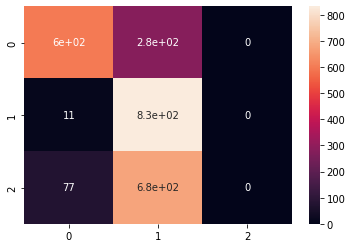

Model Accuracy:  57.65511684125705 %
Model Accuracy:  57.65511684125705 %


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
mat = sklearn.metrics.confusion_matrix(true , predicted)
print(mat)

df_cm = pd.DataFrame(mat, range(3), range(3))

sns.heatmap(df_cm, annot=True)
plt.show()
print('Model Accuracy: ', 100*sklearn.metrics.accuracy_score(true,predicted), '%')

sklearn.metrics.classification_report(true,predicted,target_names=['positive','neutral','negative'])
print('Model Accuracy: ', 100*sklearn.metrics.accuracy_score(true,predicted), '%')

## Model Demo and Testing
The get_result function allows for the model, to be loaded and use a mapped user interface for use and manual evaluation.

In [ ]:
def get_result(statement):
    result = model.predict([statement])
    print(result)
    pos = np.where(result[1][0] == np.amax(result[1][0]))
    pos = int(pos[0])
    #sentiment_dict = {0:'Flight-Planning',1:'Weather',2:'Emergency',3:'Ground-Operations', 4:'Communications'} # Convert the model outputs to the class names
    sentiment_dict = {0:'negative', 1:'positive', 2:'neutral'}
    print(sentiment_dict[pos])
    return sentiment_dict[pos]

See a manually inputted phrase

In [ ]:
print(get_result(input("Input Phrase:")))

Pre-Fabricated phrases

Should be positive

In [ ]:
print(get_result("Clear weather throughout the day"))

Should be negative

In [ ]:
print(get_result("heavy rain and low visibility in the morning"))

Should be neutral

In [ ]:
print(get_result("partly cloudy"))

# Get Program Dependencies

In [3]:
!pip freeze > requirements.txt